In [2]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from numpy.linalg import norm

In [3]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [4]:
n_321g=gto.basis.load(bse.get_basis("cc-pvdz",fmt="nwchem",elements=["N"]),"N")
c_321g=gto.basis.load(bse.get_basis("cc-pvdz",fmt="nwchem",elements=["C"]),"C")
n_321g,"*******************",c_321g

([[0,
   [9046.0, 0.0007, -0.000153, 0.0],
   [1357.0, 0.005389, -0.001208, 0.0],
   [309.3, 0.027406, -0.005992, 0.0],
   [87.73, 0.103207, -0.024544, 0.0],
   [28.56, 0.278723, -0.067459, 0.0],
   [10.21, 0.44854, -0.158078, 0.0],
   [3.838, 0.278238, -0.121831, 0.0],
   [0.7466, 0.01544, 0.549003, 0.0],
   [0.2248, -0.002864, 0.578815, 1.0]],
  [1,
   [13.55, 0.039919, 0.0],
   [2.917, 0.217169, 0.0],
   [0.7973, 0.510319, 0.0],
   [0.2185, 0.462214, 1.0]],
  [2, [0.817, 1.0]]],
 '*******************',
 [[0,
   [6665.0, 0.000692, -0.000146, 0.0],
   [1000.0, 0.005329, -0.001154, 0.0],
   [228.0, 0.027077, -0.005725, 0.0],
   [64.71, 0.101718, -0.023312, 0.0],
   [21.06, 0.27474, -0.063955, 0.0],
   [7.495, 0.448564, -0.149981, 0.0],
   [2.797, 0.285074, -0.127262, 0.0],
   [0.5215, 0.015204, 0.544529, 0.0],
   [0.1596, -0.003191, 0.580496, 1.0]],
  [1,
   [9.439, 0.038109, 0.0],
   [2.002, 0.20948, 0.0],
   [0.5456, 0.508557, 0.0],
   [0.1517, 0.468842, 1.0]],
  [2, [0.55, 1.0]]])

In [5]:
c_321=gto.basis.load(bse.get_basis("cc-pvdz",fmt="nwchem",elements=["C"]),"C")
o_321=gto.basis.load(bse.get_basis("cc-pvdz",fmt="nwchem",elements=["O"]),"O")
f_321=gto.basis.load(bse.get_basis("cc-pvdz",fmt="nwchem",elements=["F"]),"F")

In [9]:
def g321(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("cc-pvdz",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=g321(ref)
        rbm=g321(ref-1)
        rbp=g321(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  
            for j in range(1,len(fb[i])):
                for k in range(len(fb[i][j])):
                    a=(rbp[i][j][k]-rbm[i][j][k])/2
                    b=(rbp[i][j][k]+rbm[i][j][k]-2*rb[i][j][k])
                    fb[i][j][k]+=a*(z-ref)+b*(z-ref)**2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [10]:
g321(6,ref=6),"**********",g321(6.5,ref=6),"**********",g321(7,ref=6)

([[0,
   [6665.0, 0.000692, -0.000146, 0.0],
   [1000.0, 0.005329, -0.001154, 0.0],
   [228.0, 0.027077, -0.005725, 0.0],
   [64.71, 0.101718, -0.023312, 0.0],
   [21.06, 0.27474, -0.063955, 0.0],
   [7.495, 0.448564, -0.149981, 0.0],
   [2.797, 0.285074, -0.127262, 0.0],
   [0.5215, 0.015204, 0.544529, 0.0],
   [0.1596, -0.003191, 0.580496, 1.0]],
  [1,
   [9.439, 0.038109, 0.0],
   [2.002, 0.20948, 0.0],
   [0.5456, 0.508557, 0.0],
   [0.1517, 0.468842, 1.0]],
  [2, [0.55, 1.0]]],
 '**********',
 [[0,
   [7855.5, 0.000696, -0.0001495, 0.0],
   [1178.5, 0.005359, -0.0011810000000000002, 0.0],
   [268.65, 0.027241500000000002, -0.0058585, 0.0],
   [76.22, 0.1024625, -0.023927999999999998, 0.0],
   [24.81, 0.2767315, -0.065707, 0.0],
   [8.852500000000001, 0.448552, -0.1540295, 0.0],
   [3.3175, 0.281656, -0.1245465, 0.0],
   [0.63405, 0.015322, 0.546766, 0.0],
   [0.19219999999999998, -0.0030275, 0.5796555, 1.0]],
  [1,
   [11.4945, 0.039014, 0.0],
   [2.4595, 0.2133245, 0.0],
   [0.67

In [11]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

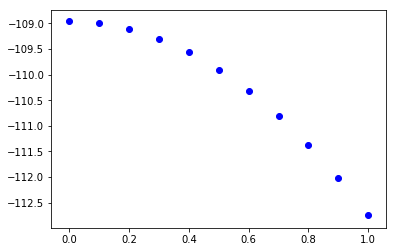

In [12]:
for i in np.linspace(0,1,11):
    plt.scatter(i,E(i),color="blue")

In [23]:
eT_R=E(-1,zbs=False)

In [17]:
e_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohrs",basis=bse.get_basis("cc-pvdz"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()
e_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("cc-pvdz"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()

converged SCF energy = -112.748289228782
converged SCF energy = -108.955359061672


In [18]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [19]:
dl=.1
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co,inc

([-108.95535906167157,
  -108.95535906167221,
  -112.75991750859562,
  -112.75991750858526,
  -112.72811970622223,
  -112.72811970626368,
  -112.7694708317504],
 -112.74828922878179,
 [-6.372680161348399e-13,
  -3.804558446923411,
  1.0362081563168126e-11,
  0.03179780236302794,
  -4.1448326252672496e-11,
  -0.041351125486717884])

In [21]:
dl=.1
Es=np.asarray([E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl)])
apdft=[e_nn]
inc=[]
for i in range(4):
    inc.append(fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_co,inc

([-108.95535906167157,
  -108.95535906167174,
  -112.75990096814846,
  -112.75990096813898,
  -112.7301707220044],
 -112.74828922878179,
 [-1.7763568394002505e-13,
  -3.8045419064767207,
  9.473903143468e-12,
  0.029730246134581265])

In [24]:
dl=.05
Es=np.asarray([E(-3*dl,zbs=False),E(-2*dl,zbs=False),E(-dl,zbs=False),e_nn,E(dl,zbs=False),E(2*dl,zbs=False),E(3*dl,zbs=False)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,eT_R,e_co,inc

([-108.95535906167157,
  -108.95535906167049,
  -110.88090069274052,
  -110.88090069292289,
  -110.90530494896112,
  -110.90530494270834,
  -110.90801357330223],
 -110.90792079509428,
 -112.74828922878179,
 [1.0791367799356522e-12,
  -1.9255416310700375,
  -1.82372635511759e-10,
  -0.024404256038224045,
  6.25277607468888e-09,
  -0.0027086305938913324])

In [25]:
def E_cn(l):
    mol_l=FcM(fcs=[-l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

In [26]:
mf_cn=scf.RHF(gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("cc-pvdz"\
                                                       ,fmt="nwchem",elements=["C","N","O"]),charge=-1))
e_cn=mf_cn.scf()

converged SCF energy = -92.2819551432902


In [27]:
dl=.1
Es=np.asarray([E_cn(-3*dl),E_cn(-2*dl),E_cn(-dl),e_nn,E_cn(dl),E_cn(2*dl),E_cn(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(np.einsum('i,i',fds7[i+1],Es)/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft=np.asarray(apdft)
apdft,e_cn,apdft-e_cn

(array([-108.95535906,  -90.67672751,  -92.32090709,  -92.28111238,
         -92.27861695,  -92.27742712,  -92.27777971]),
 -92.28195514329022,
 array([-1.66734039e+01,  1.60522763e+00, -3.89519501e-02,  8.42766564e-04,
         3.33819709e-03,  4.52802757e-03,  4.17542958e-03]))

In [26]:
#check if basis are orthonormal

In [28]:
def S(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7-l,ref=7),"N2":g321(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":g321(7,ref=7),"N2":g321(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    #e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return mf_l.get_ovlp()

In [29]:
for i in np.linspace(0,1,7):
    print(S(i).diagonal())  #automatic normalization

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


(<matplotlib.image.AxesImage at 0x7fca966e85f8>,
 <matplotlib.image.AxesImage at 0x7fca965b6240>)

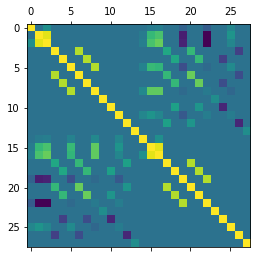

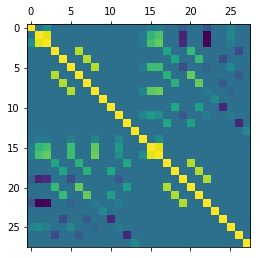

In [30]:
plt.matshow(S(0)),plt.matshow(S(.5))